# Mid-Price LSTM-New

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

## Data Pre-Processing

### Import the data

In [2]:
file_1='./LOBs_Benchmark/processed_data.csv'
data=pd.read_csv(file_1)

In [3]:
data=data.drop(columns=["Next_mid","Price_move","up_or_down"])
data.head()

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level4_Bid_Volume,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price
0,0.217,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,7.0,346.0,3.0,99.0,9.0,596.0,2.0,4.0,261.428571,260.0
1,0.124,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,...,2.0,346.0,3.0,249.0,7.0,596.0,2.0,3.0,260.500000,260.5
2,0.062,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,...,2.0,346.0,3.0,254.0,2.0,596.0,2.0,3.0,260.500000,260.5
3,0.093,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0
4,0.093,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0


### Split into the train and test data and targets - data loader

In [4]:
from sklearn.model_selection import train_test_split
data=data.astype(np.float32)
df_input=data.drop(columns=['Mid_Price'])
df_target=data['Mid_Price']
df_target = np.expand_dims(df_target, axis=1)
X_train,X_test, y_train, y_test = train_test_split(df_input, df_target,test_size=0.2,shuffle=False)
print(len(X_train), len(y_train), len(X_test), len(y_test))

714970 714970 178743 178743


### Do the normalization for the train and test data separately.

**Questions:**

1. Use which way to do the normalization (Zscore/Standardscaler)
2. Can I apply the nomalization function to the whole data. Or use them separately.
    (1) Apply to the whole(train) dataset.
    (2) Apply to the train features, and then use train features to calculate the targets.
3. How can I apply the normalzaition function to the train sets and test sets separately.(Separately)
4. Check if there are outliers with box-plot for "Time" feature. (Yeah)
5. How to deal with the outliers? (Pass it)

#### Test if the data comes from a normal distribution

In [5]:
data.describe()

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level4_Bid_Volume,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price
count,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,...,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000,893713.000000
mean,0.130912,281.361755,4.588963,303.343842,2.942673,274.940643,4.848663,331.533478,3.088295,262.348389,...,4.564046,483.670013,2.865331,204.013260,4.151733,610.735718,2.390534,21.981934,293.452850,292.352814
std,0.126968,25.194534,4.038579,48.854866,1.590442,33.914207,4.248492,87.126060,1.659635,50.981796,...,4.088905,194.834702,1.665446,92.394997,3.909286,258.302490,1.782320,48.010983,33.881241,30.583555
min,0.031000,4.000000,1.000000,232.000000,1.000000,1.000000,0.000000,233.000000,0.000000,0.001942,...,0.000000,236.000000,0.000000,0.000905,0.000000,240.000000,0.000000,1.000000,61.222221,135.000000
25%,0.062000,267.000000,2.000000,276.000000,2.000000,263.000000,2.000000,283.000000,2.000000,257.000000,...,2.000000,320.000000,1.000000,137.000000,1.000000,414.000000,1.000000,3.000000,272.769226,272.500000
50%,0.093000,279.000000,3.000000,293.000000,3.000000,276.000000,4.000000,302.000000,3.000000,272.000000,...,3.000000,435.000000,3.000000,247.000000,3.000000,583.000000,2.000000,7.000000,288.571442,288.500000
75%,0.155000,294.000000,6.000000,315.000000,4.000000,292.000000,7.000000,335.000000,4.000000,288.000000,...,6.000000,609.000000,4.000000,275.000000,6.000000,734.000000,4.000000,14.000000,306.000000,305.000000
max,3.131000,345.000000,42.000000,800.000000,16.000000,343.000000,42.000000,960.000000,16.000000,341.000000,...,44.000000,1619.500000,15.000000,336.000000,45.000000,1893.000000,15.000000,647.000000,760.230774,560.500000


/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_67476/1117119581.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Mid_Price'], shade=True)


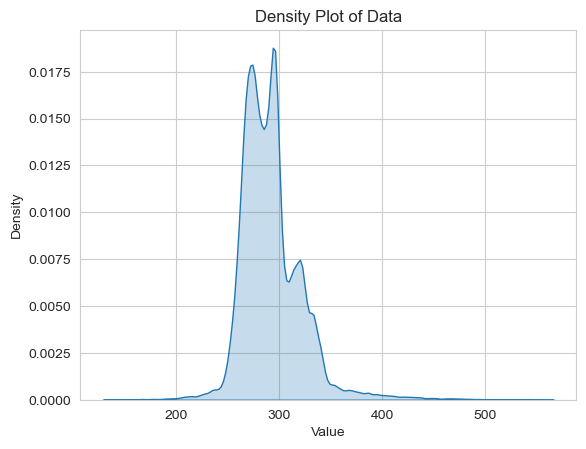

In [6]:
# import seaborn as sns
# sns.boxplot(data=Time)
import seaborn as sns

# 绘制密度图
sns.kdeplot(data['Mid_Price'], shade=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Data')
plt.show()

In [7]:
from scipy import stats
statistic, pvalue = stats.normaltest(data['level5_Ask_Price'])

# Print the test statistic and p-value
print("Test statistic:", statistic)
print("p-value:", pvalue)

# Interpret the p-value
alpha = 0.05
if pvalue < alpha:
    print("The sample does not come from a normal distribution.")
else:
    print("The sample comes from a normal distribution.")

Test statistic: 205436.72995961324
p-value: 0.0
The sample does not come from a normal distribution.


#### Use Normalization

**Zscore Normalization** (Standard Scaler)

(1) Do the normalization separately

In [8]:
from sklearn.preprocessing import StandardScaler
feature_scaler=StandardScaler()
X_train=feature_scaler.fit_transform(X_train)
X_test=feature_scaler.transform(X_test)

target_scaler=StandardScaler()
y_train=target_scaler.fit_transform(y_train)
y_test=target_scaler.transform(y_test)

(2) Based on the normalized features to calculate the targets

In [9]:
# from sklearn.preprocessing import StandardScaler
# feature_scaler=StandardScaler()
# X_train=feature_scaler.fit_transform(X_train)
# X_test=feature_scaler.transform(X_test)
#
# y_train=(X_train['level1_Ask_Price']+X_train['level1_Bid_Price'])/2
# y_test=(X_test['level1_Bid_Price']+X_test['level1_Ask_Price'])/2

### Reshape the data - Set the time steps

### Set the batch

In [10]:
def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

In [11]:
batch_size = 30 #30 is about 165 minute (5.5min per ts x 30), tried 15 and a few other values too but 30 seems to be the best

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(23833, 30, 23) (23833, 30, 1)
(5959, 30, 23) (5959, 30, 1)


#### Set the time steps

In [12]:
# don't count the Mid-price in
def df_to_time_step(df_x,df_y, window_size=30):
  # df_x_np = df_x.to_numpy()
  # df_y_np = df_y.to_numpy()
  X = []
  y = []
  for i in range(len(df_x)-window_size):
    row = [r for r in df_x[i:i+window_size]] # the whole row
    X.append(row)
    label = df_y[i+window_size] # temperature
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
# timestep=100
# X_train_step, y_train_step=df_to_time_step(X_train, y_train,timestep)
# X_test_step, y_test_step= df_to_time_step(X_test,y_test,timestep)
# print(X_train_step.shape, y_train_step.shape)
# print(X_test_step.shape, y_test_step.shape)

## Create the models

### LSTM_MODEL1

[Time Distributed Layers](https://levelup.gitconnected.com/hands-on-practice-with-time-distributed-layers-using-tensorflow-c776a5d78e7e)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [15]:
#Allows the network to accept batches of any size as input when predicting
# Make the model
model1 = Sequential()
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False, input_shape=(batch_size, 23))
model1.add(lstm)
model1.add(TimeDistributed(Dense(1, activation='linear')))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            7168      
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            33        
 ibuted)                                                         
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model
model1.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [19]:
model1_fit=model1.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Epoch 1/500


2023-05-06 09:10:00.691465: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


239/239 [==============================] - 4s 12ms/step - loss: 0.1163 - accuracy: 2.7972e-05
Epoch 2/500
239/239 [==============================] - 3s 13ms/step - loss: 0.0041 - accuracy: 2.7972e-05
Epoch 3/500
239/239 [==============================] - 3s 13ms/step - loss: 0.0018 - accuracy: 2.7972e-05
Epoch 4/500
239/239 [==============================] - 3s 13ms/step - loss: 0.0012 - accuracy: 2.7972e-05
Epoch 5/500
239/239 [==============================] - 3s 13ms/step - loss: 0.0010 - accuracy: 2.7972e-05
Epoch 6/500
239/239 [==============================] - 3s 13ms/step - loss: 8.3266e-04 - accuracy: 2.7972e-05
Epoch 7/500
239/239 [==============================] - 3s 13ms/step - loss: 7.4908e-04 - accuracy: 2.7972e-05
Epoch 8/500
239/239 [==============================] - 3s 13ms/step - loss: 6.9776e-04 - accuracy: 2.7972e-05
Epoch 9/500
239/239 [==============================] - 3s 13ms/step - loss: 6.3063e-04 - accuracy: 2.7972e-05
Epoch 10/500
239/239 [====================

In [20]:
# Predict the values
y_pred=model1.predict(X_test_batch)
print(y_pred.shape)

187/187 [==============================] - 0s 2ms/step
(5959, 30, 1)


#### Inverse_Transform and output the mean errors

In [21]:
#linear
from sklearn.metrics import mean_absolute_percentage_error
y_predict=y_pred.flatten()
y_predict_t=y_predict.reshape(-1,1)

y_test_t=y_test_batch.flatten()
y_test_t1=y_test_t.reshape(-1,1)
y_predict_o=target_scaler.inverse_transform(y_predict_t)
y_test_o=target_scaler.inverse_transform(y_test_t1)
y_predict_o=y_predict_o.flatten()
y_test_o=y_test_o.flatten()
print("MAE",mean_absolute_error(y_test_o,y_predict_o))
print("RMSE",np.sqrt(mean_squared_error(y_test_o,y_predict_o)))
print("MAPE",mean_absolute_percentage_error(y_test_o,y_predict_o))
test_results = pd.DataFrame(data={'Test Predictions':y_predict_o, 'Actuals':y_test_o})
test_results

MAE 0.18398850113751608
RMSE 0.4152016317230789
MAPE 0.0006895840615532457


,Test Predictions,Actuals
0,309.890167,310.000001
1,309.916321,310.000001
2,309.775085,310.000001
3,372.860168,373.000001
4,372.565735,373.000001
...,...,...
178765,294.183472,294.162378
178766,294.183472,294.162378
178767,294.183472,294.162378
178768,294.183472,294.162378


In [36]:
model1.save('./models/predictions_LSTM_linear')

INFO:tensorflow:Assets written to: ./models/predictions_LSTM_linear/assets


#### Plot the actual values and predictions

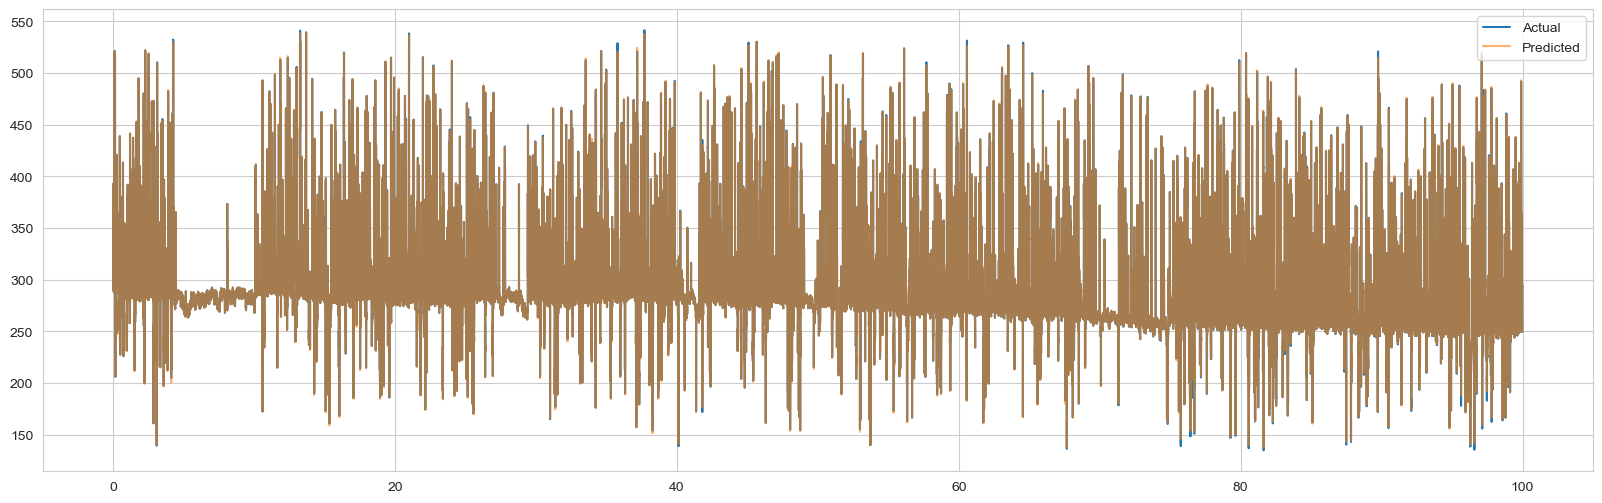

In [22]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test_o)), y_test_o, label='Actual')
plt.plot(np.linspace(0, 100, len(y_predict_o)), y_predict_o, alpha=0.6, label='Predicted')
plt.legend()

Text(0, 0.5, 'Loss')

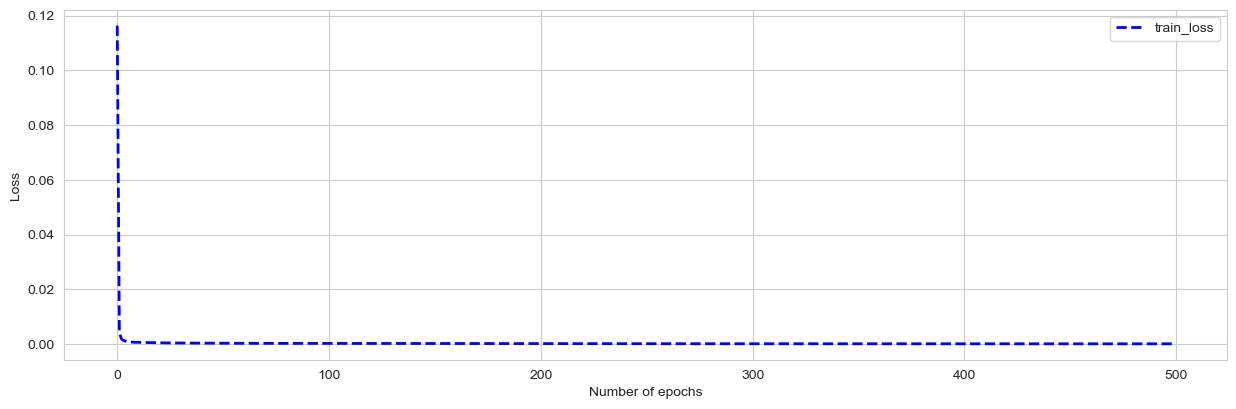

In [23]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(model1_fit.history['loss'],'b--',lw=2,label='train_loss')
# plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

In [31]:
# save the model

model1.save('./models/LSTM_model1')

INFO:tensorflow:Assets written to: ./models/LSTM_model1/assets


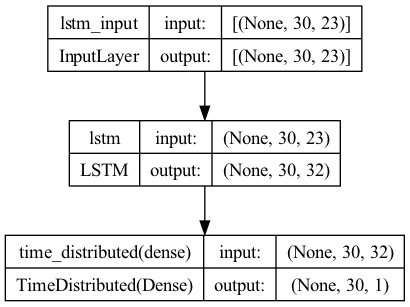

In [17]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model1, to_file='./Images_model/prediction_lstm_linear.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/prediction_lstm_linear.png')

### LSTM MODEL2

In [18]:
model2 = Sequential()
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False, input_shape=(batch_size,23))
model2.add(lstm)
# use relu
model2.add(TimeDistributed(Dense(1, activation='relu')))
model2.summary()

model2.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Fit the model
model2.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 32)            7168      
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            33        
 tributed)                                                       
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2023-05-06 17:52:52.744092: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


239/239 [==============================] - 4s 12ms/step - loss: 0.4040 - accuracy: 2.7972e-05
Epoch 2/500
239/239 [==============================] - 3s 13ms/step - loss: 0.3397 - accuracy: 2.7972e-05
Epoch 3/500
239/239 [==============================] - 3s 13ms/step - loss: 0.3385 - accuracy: 2.7972e-05
Epoch 4/500
 21/239 [=>............................] - ETA: 2s - loss: 0.3344 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [25]:
#relu
y_pred = model2.predict(X_test_batch)
print(y_pred.shape)

187/187 [==============================] - 0s 2ms/step
(5959, 30, 1)


In [27]:
from sklearn.metrics import mean_absolute_percentage_error
y_predict=y_pred.flatten()
y_predict_t=y_predict.reshape(-1,1)

y_test_t=y_test_batch.flatten()
y_test_t1=y_test_t.reshape(-1,1)
y_predict_o=target_scaler.inverse_transform(y_predict_t)
y_test_o=target_scaler.inverse_transform(y_test_t1)
y_predict_o=y_predict_o.flatten()
y_test_o=y_test_o.flatten()
print("MAE",mean_absolute_error(y_test_o,y_predict_o))
print("RMSE",np.sqrt(mean_squared_error(y_test_o,y_predict_o)))
print("MAPE",mean_absolute_percentage_error(y_test_o,y_predict_o))
test_results = pd.DataFrame(data={'Test Predictions':y_predict_o, 'Actuals':y_test_o})
test_results

MAE 18.650075716649155
MSE 26.895931661104214
MAPE 0.07386069413236367


,Test Predictions,Actuals
0,310.109253,310.000001
1,309.967407,310.000001
2,309.996277,310.000001
3,372.783173,373.000001
4,373.219818,373.000001
...,...,...
178765,294.162384,294.162378
178766,294.162384,294.162378
178767,294.162384,294.162378
178768,294.162384,294.162378


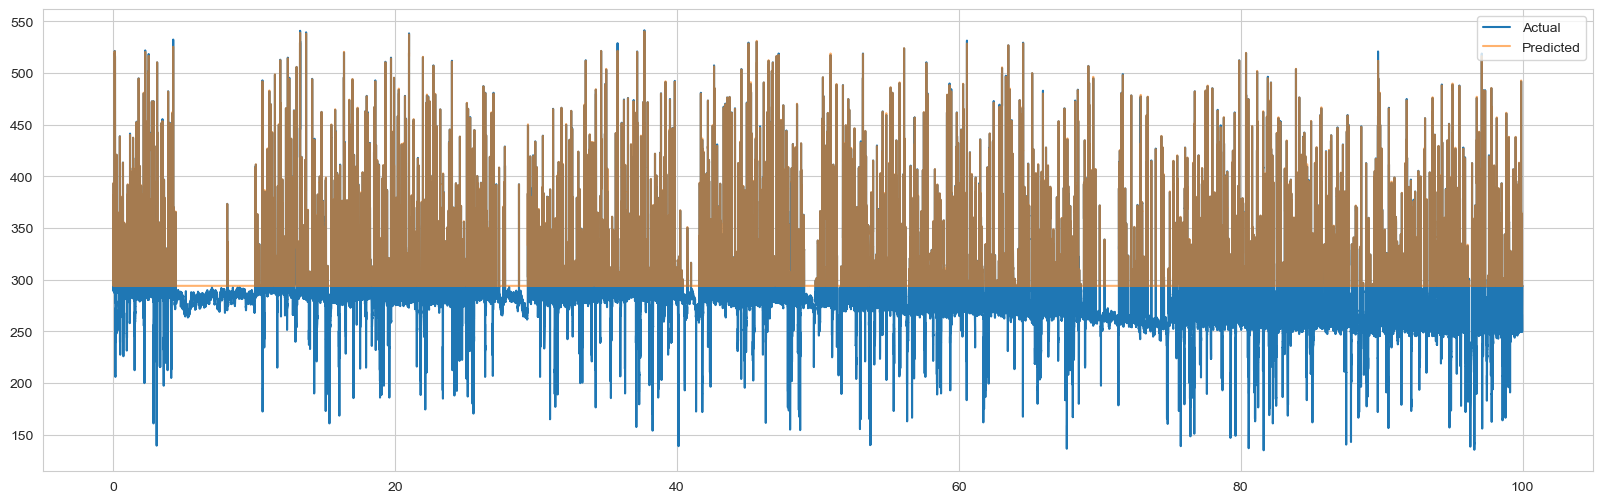

In [28]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test_o)), y_test_o, label='Actual')
plt.plot(np.linspace(0, 100, len(y_predict_o)), y_predict_o, alpha=0.6, label='Predicted')
plt.legend()

Text(0, 0.5, 'Loss')

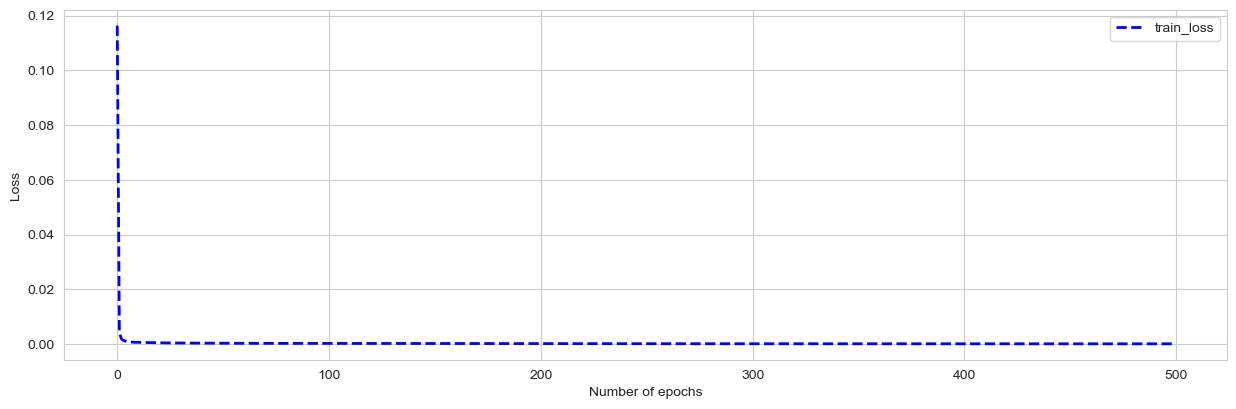

In [29]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(model1_fit.history['loss'],'b--',lw=2,label='train_loss')
# plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

In [35]:
model2.save('./models/predictions_LSTM_relu')

INFO:tensorflow:Assets written to: ./models/predictions_LSTM_relu/assets


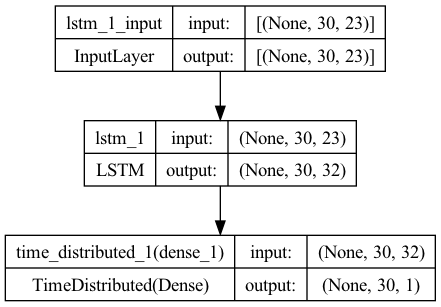

In [19]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model2, to_file='./Images_model/prediction_lstm_relu.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/prediction_lstm_relu.png')